In [1]:
%%writefile benchmark_worker.py
import sys
import time
import pandas as pd
import torch
import gc
import os
import logging
from transformers import AutoTokenizer, AutoModelForCausalLM

logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

try:
    from llm_codec import LLM_Encoder
except ImportError:
    print("Error: Could not import LLM_Encoder from llm_codec.py")
    sys.exit(1)

def run_single_benchmark(model_id, display_name, text_label, text_path, csv_path):
    print(f"--- WORKER START: {display_name} on {text_label} ---")
    
    try:
        with open(text_path, 'r', encoding='utf-8') as f:
            text = f.read()
    except FileNotFoundError:
        print(f"File not found: {text_path}")
        sys.exit(1)

    original_bytes = len(text.encode('utf-8'))

    try:
        tokenizer = AutoTokenizer.from_pretrained(model_id)
        if hasattr(tokenizer, "model_max_length"):
            tokenizer.model_max_length = 1000000
        model = AutoModelForCausalLM.from_pretrained(model_id)
    except Exception as e:
        print(f"Model load failed: {e}")
        sys.exit(1)

    # Use "block" for Novel to prevent memory leaks/crash
    strategy = "block" if text_label == "Novel (En)" else "rolling"
    
    encoder = LLM_Encoder(
        tokenizer=tokenizer,
        model=model,
        precision=32,
        context_window=2048,
        margin=128,
        device="cpu", # Safe CPU
        strategy=strategy
    )

    tik = time.time()
    encoded = encoder.encode(text, demo=False, speed_demo=False)
    enc_time = time.time() - tik
    enc_ratio = (len(encoded) * 8) / original_bytes

    print(f"DONE. Time: {enc_time:.2f}s | Ratio: {enc_ratio:.4f}")

    new_row = {
        "Text": text_label, "Model": display_name, "Time": enc_time, 
        "Ratio": enc_ratio, "Tokens": len(encoded), "Device": "CPU", "Type": "LLM"
    }
    
    header = not os.path.exists(csv_path)
    pd.DataFrame([new_row]).to_csv(csv_path, mode='a', header=header, index=False)
    sys.exit(0)

if __name__ == "__main__":
    if len(sys.argv) != 6:
        sys.exit(1)
    run_single_benchmark(sys.argv[1], sys.argv[2], sys.argv[3], sys.argv[4], sys.argv[5])

Overwriting benchmark_worker.py


In [2]:
import subprocess
import pandas as pd
import os
import time
import gzip
import sys  # <--- NEW IMPORT
from transformers import AutoTokenizer 

# --- CONFIGURATION ---
csv_filename = "benchmark_results_subprocess.csv"

files = [
    ("Sonnet (En)", "Shall I Compare Thee To a Summer's Day.txt"),
    ("Poem (Cn)", "再别康桥.txt"),
    ("News (En)", "straits_times_15_jan.txt"),
    ("News (Cn)", "zaobao_15_jan.txt"),
    ("Novel (En)", "alice29.txt")
]

models = [
    ("deepseek-ai/deepseek-coder-1.3b-base", "DeepSeek 1.3B", True),
    ("google/gemma-2b", "Gemma 2B", False),
    ("Qwen/Qwen2.5-0.5B", "Qwen 0.5B", False),
]

# 1. Reset CSV
if os.path.exists(csv_filename):
    os.remove(csv_filename)
    
# 2. Run GZIP Baseline
print("Running GZIP Baselines...")
ref_tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/deepseek-coder-1.3b-base")
gzip_results = []
for label, filename in files:
    try:
        with open(filename, 'r', encoding='utf-8') as f: text = f.read()
    except: continue
    original_bytes = len(text.encode('utf-8'))
    token_count = len(ref_tokenizer.encode(text))
    tik = time.time()
    gzip_out = gzip.compress(text.encode('utf-8'))
    gzip_time = time.time() - tik
    gzip_ratio = (len(gzip_out) * 8) / original_bytes
    gzip_results.append({
        "Text": label, "Model": "GZIP", "Time": gzip_time, 
        "Ratio": gzip_ratio, "Tokens": token_count, "Device": "CPU", "Type": "Baseline"
    })
pd.DataFrame(gzip_results).to_csv(csv_filename, index=False)
print("GZIP Done.\n")

# 3. SUBPROCESS LOOP
print("Starting Subprocess Benchmarks...")

for model_id, model_name, run_on_alice in models:
    for text_label, text_path in files:
        
        # Skip logic
        if text_label == "Novel (En)" and not run_on_alice:
            continue
            
        print(f"\n>>> Spawning Process: {model_name} -> {text_label}")
        
        try:
            # USE sys.executable TO ENSURE CORRECT PYTHON ENV
            result = subprocess.run(
                [sys.executable, "benchmark_worker.py", model_id, model_name, text_label, text_path, csv_filename],
                capture_output=True,
                text=True,
                check=True
            )
            print(result.stdout)
            
        except subprocess.CalledProcessError as e:
            print(f"!!! WORKER FAILED !!!")
            print("STDERR:", e.stderr)
            print("STDOUT:", e.stdout)
            
        time.sleep(1)

print("\n\nAll Benchmarks Complete. Data saved to:", csv_filename)

Running GZIP Baselines...


Token indices sequence length is longer than the specified maximum sequence length for this model (42272 > 16384). Running this sequence through the model will result in indexing errors
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


GZIP Done.

Starting Subprocess Benchmarks...

>>> Spawning Process: DeepSeek 1.3B -> Sonnet (En)
--- WORKER START: DeepSeek 1.3B on Sonnet (En) ---
Encoding 179 tokens via 'ROLLING' strategy...
DONE. Time: 8.22s | Ratio: 0.2759


>>> Spawning Process: DeepSeek 1.3B -> Poem (Cn)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


--- WORKER START: DeepSeek 1.3B on Poem (Cn) ---
Encoding 262 tokens via 'ROLLING' strategy...
DONE. Time: 11.68s | Ratio: 1.1348


>>> Spawning Process: DeepSeek 1.3B -> News (En)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


--- WORKER START: DeepSeek 1.3B on News (En) ---
Encoding 350 tokens via 'ROLLING' strategy...
DONE. Time: 16.00s | Ratio: 1.1355


>>> Spawning Process: DeepSeek 1.3B -> News (Cn)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


--- WORKER START: DeepSeek 1.3B on News (Cn) ---
Encoding 1213 tokens via 'ROLLING' strategy...
DONE. Time: 71.20s | Ratio: 1.2425


>>> Spawning Process: DeepSeek 1.3B -> Novel (En)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


--- WORKER START: DeepSeek 1.3B on Novel (En) ---
Encoding 42273 tokens via 'BLOCK' strategy...
DONE. Time: 2950.16s | Ratio: 1.0012


>>> Spawning Process: Gemma 2B -> Sonnet (En)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


--- WORKER START: Gemma 2B on Sonnet (En) ---
Encoding 166 tokens via 'ROLLING' strategy...
DONE. Time: 22.31s | Ratio: 0.1881


>>> Spawning Process: Gemma 2B -> Poem (Cn)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


--- WORKER START: Gemma 2B on Poem (Cn) ---
Encoding 218 tokens via 'ROLLING' strategy...
DONE. Time: 26.82s | Ratio: 1.6567


>>> Spawning Process: Gemma 2B -> News (En)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


--- WORKER START: Gemma 2B on News (En) ---
Encoding 311 tokens via 'ROLLING' strategy...
DONE. Time: 39.66s | Ratio: 0.7190


>>> Spawning Process: Gemma 2B -> News (Cn)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


--- WORKER START: Gemma 2B on News (Cn) ---
Encoding 1063 tokens via 'ROLLING' strategy...
DONE. Time: 131.27s | Ratio: 1.1387


>>> Spawning Process: Qwen 0.5B -> Sonnet (En)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


--- WORKER START: Qwen 0.5B on Sonnet (En) ---
Encoding 151 tokens via 'ROLLING' strategy...
DONE. Time: 8.46s | Ratio: 0.2759


>>> Spawning Process: Qwen 0.5B -> Poem (Cn)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


--- WORKER START: Qwen 0.5B on Poem (Cn) ---
Encoding 190 tokens via 'ROLLING' strategy...
DONE. Time: 10.62s | Ratio: 0.1816


>>> Spawning Process: Qwen 0.5B -> News (En)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


--- WORKER START: Qwen 0.5B on News (En) ---
Encoding 305 tokens via 'ROLLING' strategy...
DONE. Time: 16.66s | Ratio: 0.9472


>>> Spawning Process: Qwen 0.5B -> News (Cn)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


--- WORKER START: Qwen 0.5B on News (Cn) ---
Encoding 963 tokens via 'ROLLING' strategy...
DONE. Time: 54.84s | Ratio: 1.1563



All Benchmarks Complete. Data saved to: benchmark_results_subprocess.csv


In [ ]:
# Fixing Token Counts Script
import pandas as pd
from transformers import AutoTokenizer
import os

# Configuration
csv_file = "benchmark_results_subprocess.csv"

# Map Display Names to Model IDs
model_map = {
    "DeepSeek 1.3B": "deepseek-ai/deepseek-coder-1.3b-base",
    "Gemma 2B":      "google/gemma-2b",
    "Qwen 0.5B":     "Qwen/Qwen2.5-0.5B"
}

# Map Text Labels to Filenames
file_map = {
    "Sonnet (En)": "Shall I Compare Thee To a Summer's Day.txt",
    "Poem (Cn)":   "再别康桥.txt",
    "News (En)":   "straits_times_15_jan.txt",
    "News (Cn)":   "zaobao_15_jan.txt",
    "Novel (En)":  "alice29.txt"
}

if os.path.exists(csv_file):
    print("Loading CSV...")
    df = pd.read_csv(csv_file)
    
    # Iterate through models to load tokenizer ONCE (save time)
    for display_name, model_id in model_map.items():
        if display_name not in df['Model'].values:
            continue
            
        print(f"Fixing counts for {display_name}...")
        try:
            tokenizer = AutoTokenizer.from_pretrained(model_id)
        except Exception as e:
            print(f"Could not load tokenizer for {model_id}: {e}")
            continue
            
        # Update rows for this model
        for text_label, filename in file_map.items():
            # Find the specific row(s)
            mask = (df['Model'] == display_name) & (df['Text'] == text_label)
            
            if mask.any():
                try:
                    with open(filename, 'r', encoding='utf-8') as f:
                        text = f.read()
                    
                    # Calculate ACTUAL token count
                    correct_count = len(tokenizer.encode(text))
                    
                    # Update DataFrame
                    df.loc[mask, 'Tokens'] = correct_count
                    print(f" -> {text_label}: Updated to {correct_count} tokens")
                    
                except FileNotFoundError:
                    print(f" -> Skipping {filename} (File not found)")

    # Save back
    df.to_csv(csv_file, index=False)
    print(f"\nSuccess! {csv_file} has been repaired.")
    print("You can now run the visualization cell again.")

else:
    print(f"File {csv_file} not found. Please check the filename.")

Loading CSV...
Fixing counts for DeepSeek 1.3B...


Token indices sequence length is longer than the specified maximum sequence length for this model (42272 > 16384). Running this sequence through the model will result in indexing errors


 -> Sonnet (En): Updated to 178 tokens
 -> Poem (Cn): Updated to 261 tokens
 -> News (En): Updated to 349 tokens
 -> News (Cn): Updated to 1212 tokens
 -> Novel (En): Updated to 42272 tokens
Fixing counts for Gemma 2B...
 -> Sonnet (En): Updated to 165 tokens
 -> Poem (Cn): Updated to 217 tokens
 -> News (En): Updated to 310 tokens
 -> News (Cn): Updated to 1062 tokens
Fixing counts for Qwen 0.5B...


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 0254c077-3016-4422-8ac7-c7c6c02df858)')' thrown while requesting HEAD https://huggingface.co/Qwen/Qwen2.5-0.5B/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].


 -> Sonnet (En): Updated to 150 tokens
 -> Poem (Cn): Updated to 189 tokens
 -> News (En): Updated to 304 tokens
 -> News (Cn): Updated to 962 tokens

Success! benchmark_results_subprocess.csv has been repaired.
You can now run the visualization cell again.


/var/folders/9q/kr6k165j47b7qv4mlqdh4_9r0000gn/T/ipykernel_65416/2632184245.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


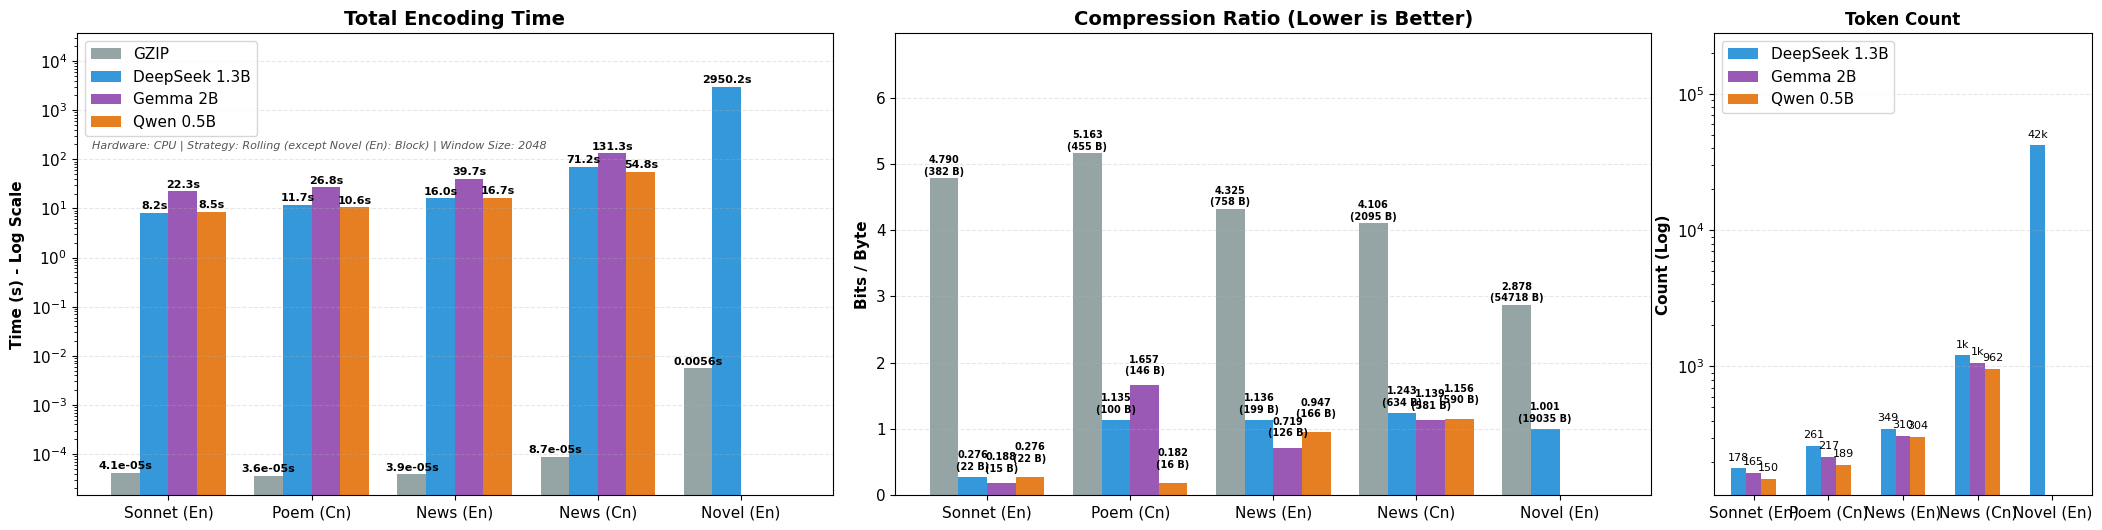

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# --- LOAD DATA ---
csv_file = "benchmark_results_subprocess.csv"
if not os.path.exists(csv_file):
    csv_file = "benchmark_results.csv"

if os.path.exists(csv_file):
    df = pd.read_csv(csv_file)
else:
    print("Error: No CSV file found.")
    df = pd.DataFrame()

if not df.empty:
    # Setup styling
    plt.rcParams.update({'font.size': 11})
    
    # Define models and colors
    available_models = df['Model'].unique()
    
    model_colors = {
        "GZIP": "#95a5a6",          # Grey
        "DeepSeek 1.3B": "#3498db", # Blue
        "Gemma 2B": "#9b59b6",      # Purple
        "Qwen 0.5B": "#e67e22"      # Orange
    }
    
    preferred_order = ["Sonnet (En)", "Poem (Cn)", "News (En)", "News (Cn)", "Novel (En)"]
    texts_present = [t for t in preferred_order if t in df['Text'].unique()]
    
    # Map text labels to filenames for original byte sizes
    text_file_map = {
        "Sonnet (En)": "Shall I Compare Thee To a Summer's Day.txt",
        "Poem (Cn)": "再别康桥.txt",
        "News (En)": "straits_times_15_jan.txt",
        "News (Cn)": "zaobao_15_jan.txt",
        "Novel (En)": "alice29.txt",
    }
    original_bytes_map = {}
    for label in texts_present:
        path = text_file_map.get(label)
        if path and os.path.exists(path):
            with open(path, "rb") as f:
                original_bytes_map[label] = len(f.read())
    
    # --- PLOTTING LAYOUT ---
    # One row with three columns: Time (40%), Ratio (40%), Tokens (20%)
    fig = plt.figure(figsize=(26, 6))
    gs = fig.add_gridspec(1, 3, width_ratios=[0.4, 0.4, 0.2], wspace=0.1)
    
    ax_time = fig.add_subplot(gs[0, 0])
    ax_ratio = fig.add_subplot(gs[0, 1])
    ax_tok = fig.add_subplot(gs[0, 2])
    
    x = np.arange(len(texts_present))
    width = 0.2
    
    # Offsets
    num_models = len(available_models)
    offsets = np.linspace(-width * (num_models - 1) / 2, width * (num_models - 1) / 2, num_models)

    # ==========================================
    # 1. TIME PLOT (Left, Log Scale, Sci Notation)
    # ==========================================
    for i, model in enumerate(available_models):
        subset = df[df['Model'] == model]
        heights = []
        for t in texts_present:
            row = subset[subset['Text'] == t]
            val = row['Time'].values[0] if not row.empty else 0
            heights.append(val)
        
        bars = ax_time.bar(x + offsets[i], heights, width, label=model, color=model_colors.get(model, 'black'))
        
        for bar in bars:
            h = bar.get_height()
            if h > 0:
                # --- FORMATTING LOGIC ---
                if h < 0.001:
                    fmt = f'{h:.1e}s' # Scientific: 1.2e-4s
                elif h < 0.01:
                    fmt = f'{h:.4f}s' # High precision: 0.0052s
                elif h < 0.1:
                    fmt = f'{h:.3f}s' # Medium precision: 0.052s
                else:
                    fmt = f'{h:.1f}s' # Standard: 1.5s
                # ------------------------
                    
                ax_time.text(
                    bar.get_x() + bar.get_width()/2, 
                    h * 1.08, 
                    fmt, 
                    ha='center', va='bottom', fontsize=8, rotation=0, fontweight='bold'
                )

    system_info = "Hardware: CPU | Strategy: Rolling (except Novel (En): Block) | Window Size: 2048"
    ax_time.text(0.02, 0.75, system_info, transform=ax_time.transAxes, 
                fontsize=8, color='#555555', style='italic', 
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    ax_time.set_ylabel('Time (s) - Log Scale', fontweight='bold')
    ax_time.set_title('Total Encoding Time', fontweight='bold', fontsize=14)
    ax_time.set_xticks(x)
    ax_time.set_xticklabels(texts_present)
    ax_time.set_yscale('log')
    ax_time.legend(loc='upper left')
    ax_time.grid(axis='y', linestyle='--', alpha=0.3)
    ax_time.set_ylim(top=ax_time.get_ylim()[1] * 5)

    # ==========================================
    # 2. RATIO PLOT (Middle)
    # ==========================================
    max_ratio = 0
    for i, model in enumerate(available_models):
        subset = df[df['Model'] == model]
        heights = []
        bytes_per_text = []
        for t in texts_present:
            row = subset[subset['Text'] == t]
            ratio_val = row['Ratio'].values[0] if not row.empty else 0
            heights.append(ratio_val)
            max_ratio = max(max_ratio, ratio_val)
            original_bytes = original_bytes_map.get(t)
            if original_bytes is not None and ratio_val > 0:
                bytes_per_text.append(int(round((ratio_val * original_bytes) / 8)))
            else:
                bytes_per_text.append(None)
            
        bars = ax_ratio.bar(x + offsets[i], heights, width, label=model, color=model_colors.get(model, 'black'))
        label_offset = 0.02 + (i * 0.06)
        
        for bar, comp_bytes in zip(bars, bytes_per_text):
            h = bar.get_height()
            if h > 0:
                label = f'{h:.3f}'
                if comp_bytes is not None:
                    label = f'{h:.3f}\n({comp_bytes} B)'
                ax_ratio.text(
                    bar.get_x() + bar.get_width()/2, 
                    h + label_offset, 
                    label,
                    ha='center', va='bottom', fontsize=7, fontweight='bold'
                )

    ax_ratio.set_ylabel('Bits / Byte', fontweight='bold')
    ax_ratio.set_title('Compression Ratio (Lower is Better)', fontweight='bold', fontsize=14)
    ax_ratio.set_xticks(x)
    ax_ratio.set_xticklabels(texts_present)
    ax_ratio.grid(axis='y', linestyle='--', alpha=0.3)
    if max_ratio > 0:
        ax_ratio.set_ylim(0, max_ratio * 1.35)

    # ==========================================
    # 3. TOKEN PLOT (Right - SMALL)
    # ==========================================
    llm_models = [m for m in available_models if m != "GZIP"]
    num_llms = len(llm_models)
    
    if num_llms > 0:
        llm_offsets = np.linspace(-width * (num_llms - 1) / 2, width * (num_llms - 1) / 2, num_llms)
    
        for i, model in enumerate(llm_models):
            subset = df[df['Model'] == model]
            heights = []
            for t in texts_present:
                row = subset[subset['Text'] == t]
                val = row['Tokens'].values[0] if not row.empty else 0
                heights.append(val)
                
            bars = ax_tok.bar(x + llm_offsets[i], heights, width, label=model, color=model_colors.get(model, 'black'))
            
            for bar in bars:
                h = bar.get_height()
                if h > 0:
                    # Simplified annotation for small plot
                    if h > 1000:
                        lbl = f'{int(h)/1000:.0f}k'
                    else:
                        lbl = f'{int(h)}'
                        
                    ax_tok.text(
                        bar.get_x() + bar.get_width()/2, 
                        h * 1.1, 
                        lbl, 
                        ha='center', va='bottom', fontsize=8
                    )
    
    ax_tok.set_ylabel('Count (Log)', fontweight='bold')
    ax_tok.set_title('Token Count', fontweight='bold', fontsize=12)
    ax_tok.set_xticks(x)
    ax_tok.set_xticklabels(texts_present, rotation=0)
    ax_tok.set_yscale('log')
    ax_tok.legend(loc='upper left')
    ax_tok.grid(axis='y', linestyle='--', alpha=0.3)
    ax_tok.set_ylim(top=ax_tok.get_ylim()[1] * 5)

    plt.tight_layout()
    plt.savefig('benchmark_plot.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("DataFrame is empty.")

/var/folders/9q/kr6k165j47b7qv4mlqdh4_9r0000gn/T/ipykernel_65416/1838066923.py:234: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


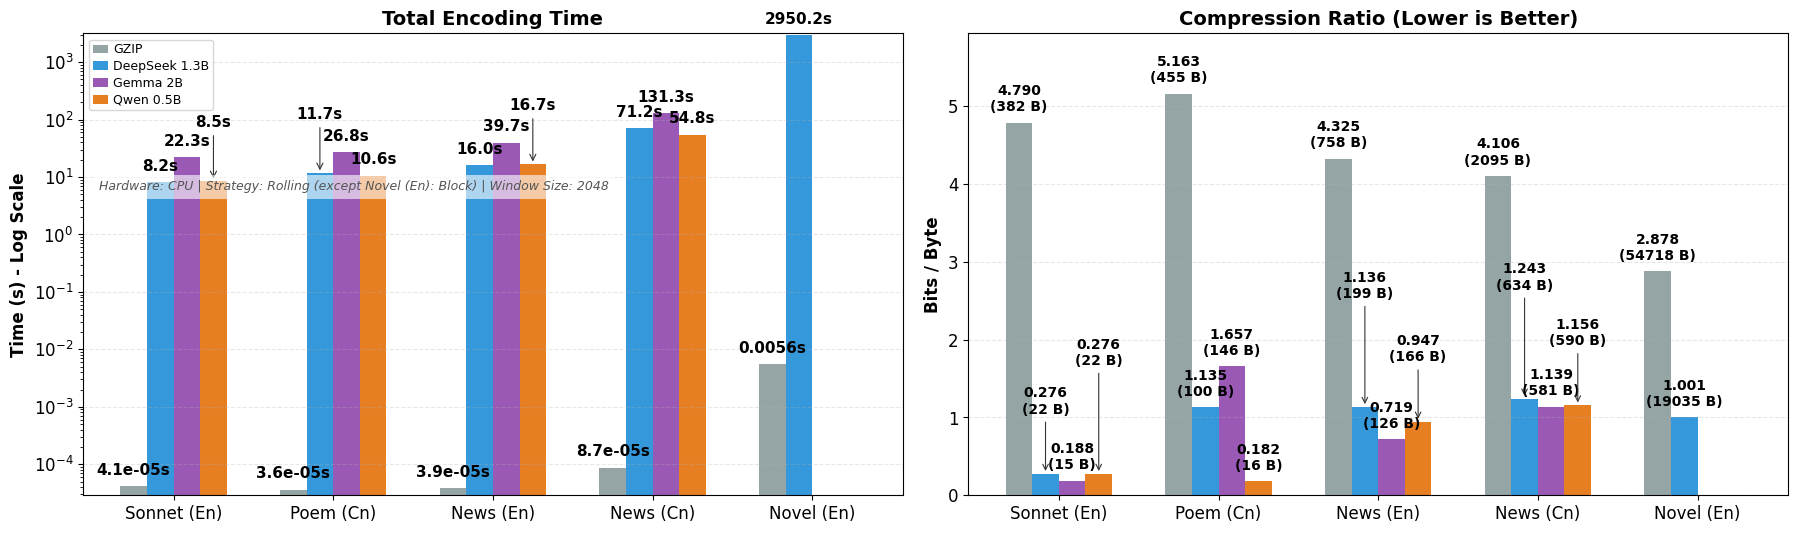

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# --- LOAD DATA ---
csv_file = "benchmark_results_subprocess.csv"
if not os.path.exists(csv_file):
    csv_file = "benchmark_results.csv"

if os.path.exists(csv_file):
    df = pd.read_csv(csv_file)
else:
    print("Error: No CSV file found.")
    df = pd.DataFrame()

if not df.empty:
    # Setup styling
    plt.rcParams.update({'font.size': 12})
    
    # Adjustable staggering scale (increase to stagger more)
    stagger_scale = 2.2
    
    # Overall height scale (lower to reduce bar heights)
    time_ylim_scale = 1.08
    ratio_ylim_scale = 1.15
    
    # Label offset tuning (in points)
    time_label_base_pts = 6
    time_label_step_pts = 14 * stagger_scale
    ratio_label_base_pts = 6
    ratio_label_step_pts = 16 * stagger_scale
    
    # Define models and colors
    available_models = df['Model'].unique()
    
    model_colors = {
        "GZIP": "#95a5a6",          # Grey
        "DeepSeek 1.3B": "#3498db", # Blue
        "Gemma 2B": "#9b59b6",      # Purple
        "Qwen 0.5B": "#e67e22"      # Orange
    }
    
    preferred_order = ["Sonnet (En)", "Poem (Cn)", "News (En)", "News (Cn)", "Novel (En)"]
    texts_present = [t for t in preferred_order if t in df['Text'].unique()]
    
    # Map text labels to filenames for original byte sizes
    text_file_map = {
        "Sonnet (En)": "Shall I Compare Thee To a Summer's Day.txt",
        "Poem (Cn)": "再别康桥.txt",
        "News (En)": "straits_times_15_jan.txt",
        "News (Cn)": "zaobao_15_jan.txt",
        "Novel (En)": "alice29.txt",
    }
    original_bytes_map = {}
    for label in texts_present:
        path = text_file_map.get(label)
        if path and os.path.exists(path):
            with open(path, "rb") as f:
                original_bytes_map[label] = len(f.read())
    
    # --- PLOTTING LAYOUT ---
    # One row with two columns: Time (50%), Ratio (50%)
    fig = plt.figure(figsize=(22, 6))
    gs = fig.add_gridspec(1, 2, width_ratios=[0.5, 0.5], wspace=0.08)
    
    ax_time = fig.add_subplot(gs[0, 0])
    ax_ratio = fig.add_subplot(gs[0, 1])
    
    # Add spacing between category groups
    group_gap = 1.2
    x = np.arange(len(texts_present)) * group_gap
    width = 0.2
    
    # Offsets
    num_models = len(available_models)
    offsets = np.linspace(-width * (num_models - 1) / 2, width * (num_models - 1) / 2, num_models)

    # Helper to compute stagger levels within each text group
    def compute_stagger_levels(heights, rel_threshold=0.24, abs_threshold=0.12):
        indexed = [(i, h) for i, h in enumerate(heights) if h > 0]
        if not indexed:
            return [0 for _ in heights]
        vals = [h for _, h in indexed]
        h_min, h_max = min(vals), max(vals)
        rel_span = (h_max - h_min) / max(h_max, 1e-9)
        abs_span = h_max - h_min
        # If bars are close, force aggressive staggering by model order
        if rel_span < rel_threshold or abs_span < abs_threshold:
            return [i for i in range(len(heights))]
        # Otherwise, stagger only close neighbors by sorted height
        indexed.sort(key=lambda t: t[1])
        levels = {i: 0 for i, _ in indexed}
        prev_h = None
        level = 0
        for i, h in indexed:
            if prev_h is not None:
                rel_gap = abs(h - prev_h) / max(prev_h, 1e-9)
                abs_gap = abs(h - prev_h)
                if rel_gap < rel_threshold or abs_gap < abs_threshold:
                    level += 1
                else:
                    level = 0
            levels[i] = level
            prev_h = h
        return [levels.get(i, 0) for i in range(len(heights))]

    # Precompute per-text stagger levels for time and ratio
    time_levels = []
    ratio_levels = []
    for t in texts_present:
        time_heights = []
        ratio_heights = []
        for model in available_models:
            subset = df[(df['Model'] == model) & (df['Text'] == t)]
            time_val = subset['Time'].values[0] if not subset.empty else 0
            ratio_val = subset['Ratio'].values[0] if not subset.empty else 0
            time_heights.append(time_val)
            ratio_heights.append(ratio_val)
        time_levels.append(compute_stagger_levels(time_heights, rel_threshold=0.28, abs_threshold=0.10))
        ratio_levels.append(compute_stagger_levels(ratio_heights, rel_threshold=0.40, abs_threshold=0.16))

    time_positive = [v for v in df['Time'].values if v > 0]
    time_min = min(time_positive) if time_positive else 1e-6
    time_max = max(time_positive) if time_positive else 1.0

    # ==========================================
    # 1. TIME PLOT (Left, Log Scale, Sci Notation)
    # ==========================================
    for i, model in enumerate(available_models):
        subset = df[df['Model'] == model]
        heights = []
        for t in texts_present:
            row = subset[subset['Text'] == t]
            val = row['Time'].values[0] if not row.empty else 0
            heights.append(val)
        
        bars = ax_time.bar(x + offsets[i], heights, width, label=model, color=model_colors.get(model, 'black'))
        
        for j, bar in enumerate(bars):
            h = bar.get_height()
            if h > 0:
                if h < 0.001:
                    fmt = f'{h:.1e}s'
                elif h < 0.01:
                    fmt = f'{h:.4f}s'
                elif h < 0.1:
                    fmt = f'{h:.3f}s'
                else:
                    fmt = f'{h:.1f}s'
                level = time_levels[j][i]
                x0 = bar.get_x() + bar.get_width()/2
                y_offset = time_label_base_pts + level * time_label_step_pts
                ax_time.annotate(
                    fmt,
                    xy=(x0, h),
                    xytext=(0, y_offset),
                    textcoords='offset points',
                    ha='center', va='bottom', fontsize=11, fontweight='bold',
                    arrowprops=dict(arrowstyle='->', lw=0.8, color='#333333') if level >= 1 else None
                )

    system_info = "Hardware: CPU | Strategy: Rolling (except Novel (En): Block) | Window Size: 2048"
    ax_time.text(0.02, 0.66, system_info, transform=ax_time.transAxes, 
                fontsize=9, color='#555555', style='italic', 
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    ax_time.set_ylabel('Time (s) - Log Scale', fontweight='bold')
    ax_time.set_title('Total Encoding Time', fontweight='bold', fontsize=14)
    ax_time.set_xticks(x)
    ax_time.set_xticklabels(texts_present)
    ax_time.set_yscale('log')
    ax_time.legend(
        loc='upper left',
        fontsize=9,
        frameon=True,
        framealpha=0.8,
        borderpad=0.3,
        labelspacing=0.3,
        handlelength=1.2,
        handletextpad=0.4,
        columnspacing=0.6
    )
    ax_time.grid(axis='y', linestyle='--', alpha=0.3)
    ax_time.set_ylim(time_min * 0.8, time_max * time_ylim_scale)

    # ==========================================
    # 2. RATIO PLOT (Right)
    # ==========================================
    max_ratio = 0
    for i, model in enumerate(available_models):
        subset = df[df['Model'] == model]
        heights = []
        bytes_per_text = []
        for t in texts_present:
            row = subset[subset['Text'] == t]
            ratio_val = row['Ratio'].values[0] if not row.empty else 0
            heights.append(ratio_val)
            max_ratio = max(max_ratio, ratio_val)
            original_bytes = original_bytes_map.get(t)
            if original_bytes is not None and ratio_val > 0:
                bytes_per_text.append(int(round((ratio_val * original_bytes) / 8)))
            else:
                bytes_per_text.append(None)
            
        bars = ax_ratio.bar(x + offsets[i], heights, width, label=model, color=model_colors.get(model, 'black'))
        
        for j, (bar, comp_bytes) in enumerate(zip(bars, bytes_per_text)):
            h = bar.get_height()
            if h > 0:
                label = f'{h:.3f}'
                if comp_bytes is not None:
                    label = f'{h:.3f}\n({comp_bytes} B)'
                level = ratio_levels[j][i]
                x0 = bar.get_x() + bar.get_width()/2
                y_offset = ratio_label_base_pts + level * ratio_label_step_pts
                ax_ratio.annotate(
                    label,
                    xy=(x0, h),
                    xytext=(0, y_offset),
                    textcoords='offset points',
                    ha='center', va='bottom', fontsize=10, fontweight='bold',
                    arrowprops=dict(arrowstyle='->', lw=0.8, color='#333333') if level >= 1 else None
                )

    ax_ratio.set_ylabel('Bits / Byte', fontweight='bold')
    ax_ratio.set_title('Compression Ratio (Lower is Better)', fontweight='bold', fontsize=14)
    ax_ratio.set_xticks(x)
    ax_ratio.set_xticklabels(texts_present)
    ax_ratio.grid(axis='y', linestyle='--', alpha=0.3)
    if max_ratio > 0:
        ax_ratio.set_ylim(0, max_ratio * ratio_ylim_scale)

    plt.tight_layout()
    plt.savefig('benchmark_plot_widebars.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("DataFrame is empty.")

/var/folders/9q/kr6k165j47b7qv4mlqdh4_9r0000gn/T/ipykernel_65651/1250249147.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


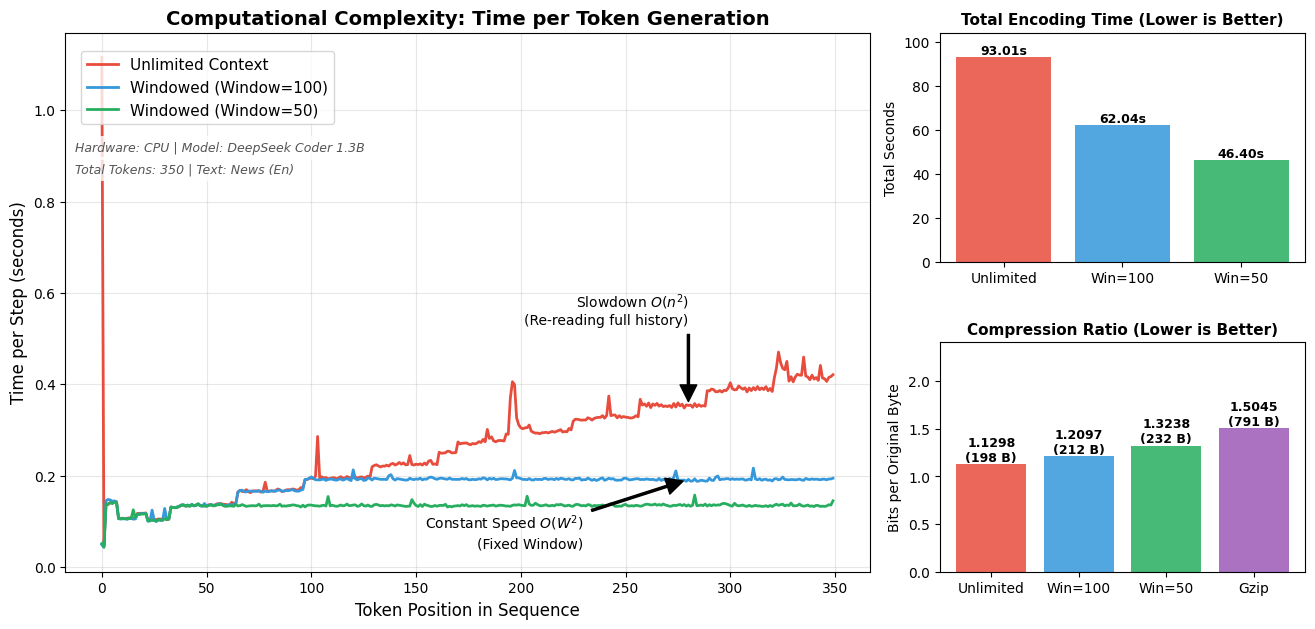

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Load the Speed Data
# (Assuming variables are already in memory from previous cells, 
# but reloading here for safety if you run this cell independently)
try:
    df_inf = pd.read_csv("llm_encode_probs_straits_times_15_jan_inf.csv")
    df_win100 = pd.read_csv("llm_encode_probs_straits_times_15_jan_win.csv")
    df_win50 = pd.read_csv("llm_encode_probs_straits_times_15_jan_win_50.csv")
except FileNotFoundError:
    print("CSVs not found. Please run the experiments in the previous cells first.")

# 2. Setup the Dashboard Layout
# Main complexity plot on the left, time/ratio stacked on the right
fig = plt.figure(figsize=(16, 7))
gs = fig.add_gridspec(2, 2, width_ratios=[2.2, 1], height_ratios=[1, 1], wspace=0.12, hspace=0.35)

ax_speed = fig.add_subplot(gs[:, 0])     # Left column (full height)
ax_time  = fig.add_subplot(gs[0, 1])     # Right top
ax_ratio = fig.add_subplot(gs[1, 1])     # Right bottom

# --- PLOT 1: Speed per Token ---
# Infinite Context (Red)
ax_speed.plot(df_inf['pos'], df_inf['time'], 
              color='#e74c3c', linewidth=2, label='Unlimited Context')

# Windowed Context 100 (Blue)
ax_speed.plot(df_win100['pos'], df_win100['time'], 
              color='#3498db', linewidth=2, label='Windowed (Window=100)')

# Windowed Context 50 (Green)
ax_speed.plot(df_win50['pos'], df_win50['time'], 
              color='#27ae60', linewidth=2, label='Windowed (Window=50)')

ax_speed.set_title('Computational Complexity: Time per Token Generation', fontsize=14, fontweight='bold')
ax_speed.set_ylabel('Time per Step (seconds)', fontsize=12)
ax_speed.set_xlabel('Token Position in Sequence', fontsize=12)
ax_speed.grid(True, alpha=0.3)

# Add Legend
legend = ax_speed.legend(fontsize=11, loc='upper left', bbox_to_anchor=(0.01, 0.98))

# Add System Info Text underneath the legend
system_info = "Hardware: CPU | Model: DeepSeek Coder 1.3B"
ax_speed.text(0.012, 0.78, system_info, transform=ax_speed.transAxes, 
              fontsize=9, color='#555555', style='italic', 
              bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# add text info underneath the system info
text_info = f"Total Tokens: {len(df_inf)} | Text: News (En)"
ax_speed.text(0.012, 0.74, text_info, transform=ax_speed.transAxes, 
              fontsize=9, color='#555555', style='italic', 
              bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# --- REFINED ANNOTATIONS ---
# 1. Unlimited Context
target_idx_inf = int(len(df_inf) * 0.8)
target_y_inf = df_inf['time'].iloc[target_idx_inf]

ax_speed.annotate('Slowdown $O(n^2)$\n(Re-reading full history)', 
                  xy=(target_idx_inf, target_y_inf), 
                  xytext=(target_idx_inf, target_y_inf * 1.5),
                  arrowprops=dict(facecolor='black', shrink=0.05, width=1.5), 
                  fontsize=10, ha='right')

# 2. Windowed Context (100)
target_idx_win = int(len(df_win100) * 0.8)
target_y_win = df_win100['time'].iloc[target_idx_win]

ax_speed.annotate('Constant Speed $O(W^2)$\n(Fixed Window)', 
                  xy=(target_idx_win, target_y_win), 
                  xytext=(target_idx_win - 50, target_y_win - 0.15),
                  arrowprops=dict(facecolor='black', shrink=0.05, width=1.5), 
                  fontsize=10, ha='right')

# --- PLOT 2: Total Encoding Time ---
labels = ['Unlimited', 'Win=100', 'Win=50']
labels_compression_ratios = ['Unlimited', 'Win=100', 'Win=50', 'Gzip']

# Use provided measurements
times = [93.0124, 62.0393, 46.4021]
ratios = [1.1298, 1.2097, 1.3238]
size_of_encoded = 198
size_of_encoded_win = 212
size_of_encoded_win_50 = 232
size_of_gzip_val = size_of_gzip if 'size_of_gzip' in globals() else 0
sizes_bytes = [size_of_encoded, size_of_encoded_win, size_of_encoded_win_50, size_of_gzip_val]

colors = ['#e74c3c', '#3498db', '#27ae60']
bars = ax_time.bar(labels, times, color=colors, alpha=0.85)
ax_time.set_title('Total Encoding Time (Lower is Better)', fontsize=11, fontweight='bold')
ax_time.set_ylabel('Total Seconds', fontsize=10)
if len(times) > 0:
    ax_time.set_ylim(0, max(times) * 1.12)

for bar in bars:
    height = bar.get_height()
    ax_time.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}s', ha='center', va='bottom', fontweight='bold', fontsize=9)

# --- PLOT 3: Compression Ratio ---
bars_r = ax_ratio.bar(labels_compression_ratios, ratios + [compression_ratio_gzip], color=colors + ['#9b59b6'], alpha=0.85)
ax_ratio.set_title('Compression Ratio (Lower is Better)', fontsize=11, fontweight='bold')
ax_ratio.set_ylabel('Bits per Original Byte', fontsize=10)
if len(ratios) > 0:
    y_max = max(ratios + [compression_ratio_gzip])
    ax_ratio.set_ylim(0, y_max * 1.6)

for bar, ratio_val, size_b in zip(bars_r, ratios + [compression_ratio_gzip], sizes_bytes):
    height = bar.get_height()
    ax_ratio.text(bar.get_x() + bar.get_width()/2., height,
                 f'{ratio_val:.4f}\n({size_b} B)', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
# time ratio vs. gzip
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- LOAD DATA ---
csv_file = "benchmark_results_subprocess.csv"

if os.path.exists(csv_file):
    df = pd.read_csv(csv_file)

df_time = df[df['Type'] == 'LLM'][['Text', 'Model', 'Time']].rename(columns={'Time': 'LLM_Time'})
df_gzip = df[df['Type'] == 'Baseline'][['Text', 'Time']].rename(columns={'Time': 'GZIP_Time'})


In [6]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import subprocess
import numpy as np

# ==========================================
# 1. SETUP: WORKER SCRIPT
# ==========================================
worker_code = """
import sys
import time
import psutil
import os
import pandas as pd
import torch
import gc
import threading
from transformers import AutoTokenizer, AutoModelForCausalLM

try:
    from llm_codec import LLM_Encoder
except ImportError:
    sys.exit(1)

def run_stress_test(strategy, device, filename, limit, window_size, output_id):
    memory_log = []
    stop_monitor = False
    process = psutil.Process(os.getpid())
    start_time = time.time()

    def monitor():
        while not stop_monitor:
            try:
                mem_info = process.memory_info()
                rss_mb = mem_info.rss / (1024 * 1024)
                vms_mb = mem_info.vms / (1024 * 1024)
                elapsed = time.time() - start_time
                memory_log.append({"time": elapsed, "rss_mb": rss_mb, "vms_mb": vms_mb})
                time.sleep(0.05)
            except:
                break

    monitor_thread = threading.Thread(target=monitor)
    monitor_thread.start()

    try:
        model_id = "deepseek-ai/deepseek-coder-1.3b-base"
        tokenizer = AutoTokenizer.from_pretrained(model_id)
        model = AutoModelForCausalLM.from_pretrained(model_id)
        
        with open(filename, 'r', encoding='utf-8') as f: full_text = f.read()
        all_ids = tokenizer.encode(full_text)
        if len(all_ids) > limit: all_ids = all_ids[:limit]
        safe_text = tokenizer.decode(all_ids)

        if device == "cpu": model.to("cpu")
        elif device == "mps": model.to("mps")

        encoder = LLM_Encoder(
            tokenizer=tokenizer, model=model, strategy=strategy,
            context_window=window_size, margin=32, device=device
        )
        
        speed_csv = f"temp_speed_{output_id}.csv"
        encoder.encode(safe_text, demo=False, speed_demo=True, speed_csv_path=speed_csv)
        
    except Exception as e:
        print(f"Worker Error: {e}")
    finally:
        stop_monitor = True
        monitor_thread.join()

    pd.DataFrame(memory_log).to_csv(f"temp_memory_{output_id}.csv", index=False)
    sys.exit(0)

if __name__ == "__main__":
    if len(sys.argv) >= 7:
        run_stress_test(sys.argv[1], sys.argv[2], sys.argv[3], int(sys.argv[4]), int(sys.argv[5]), sys.argv[6])
"""

with open("stress_test_worker_vms.py", "w") as f:
    f.write(worker_code)

# ==========================================
# 2. GENERATE DATA (If needed)
# ==========================================
filename = "alice29.txt"
target_tokens = 3500
window_size = 512
configs = [("rolling", "mps"), ("block", "mps"), ("rolling", "cpu"), ("block", "cpu")]
results = {}

print(f"=== Generating Data ({target_tokens} tokens) ===")

for strategy, device in configs:
    if device == "mps" and not os.path.exists("/System/Library"): continue
        
    test_id = f"{strategy}_{device}"
    print(f">>> Running: {strategy.upper()} on {device.upper()}...")
    
    cmd = [sys.executable, "stress_test_worker_vms.py", strategy, device, filename, str(target_tokens), str(window_size), test_id]
    
    try:
        subprocess.run(cmd, check=True)
        
        # Load and Align
        df_speed = pd.read_csv(f"temp_speed_{test_id}.csv")
        df_mem = pd.read_csv(f"temp_memory_{test_id}.csv")
        
        df_speed['elapsed'] = df_speed['time'].cumsum()
        # Align Memory Time -> Token Position
        estimated_pos = np.interp(df_mem['time'], df_speed['elapsed'], df_speed['pos'])
        df_mem['aligned_pos'] = estimated_pos
        
        results[test_id] = {"speed": df_speed, "mem": df_mem}
        
        # Cleanup
        os.remove(f"temp_speed_{test_id}.csv")
        os.remove(f"temp_memory_{test_id}.csv")
        
    except Exception as e:
        print(f"Failed {test_id}: {e}")

print("\nData Ready. Plotting...")

# ==========================================
# 3. HORIZONTAL VISUALIZATION (1 Row, 3 Cols)
# ==========================================
# Layout: [Latency] [VMS] [RSS]
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True)

ax_speed, ax_vms, ax_rss = axes

# Styling Configuration
styles = {
    "rolling": {"color": "#d62728", "label": "Rolling"}, # Red
    "block":   {"color": "#2ca02c", "label": "Block"}    # Green
}
linestyles = {
    "mps": "-",   # Solid
    "cpu": "--"   # Dashed
}

# Titles & Labels
ax_speed.set_title("1. Latency (Lag)", fontsize=14, fontweight='bold')
ax_speed.set_ylabel("Seconds / Token")
ax_speed.set_xlabel("Token Position")

ax_vms.set_title("2. Virtual Memory (Leak)", fontsize=14, fontweight='bold')
ax_vms.set_ylabel("VMS (MB)")
ax_vms.set_xlabel("Token Position")

ax_rss.set_title("3. Physical RAM (RSS)", fontsize=14, fontweight='bold')
ax_rss.set_ylabel("RSS (MB)")
ax_rss.set_xlabel("Token Position")

# Plotting Loop
for key, data in results.items():
    strategy, device = key.split("_")
    
    df_speed = data["speed"]
    df_mem = data["mem"]
    
    # Construct Label and Style
    label = f"{strategy.upper()} ({device.upper()})"
    color = styles[strategy]["color"]
    ls = linestyles[device]
    
    # 1. Latency (Smoothed)
    smooth = df_speed["time"].rolling(20).mean()
    ax_speed.plot(df_speed["pos"], smooth, label=label, color=color, linestyle=ls, linewidth=1.5, alpha=0.8)
    
    # 2. Memory (Aligned)
    mask = (df_mem['aligned_pos'] >= 0) & (df_mem['aligned_pos'] <= df_speed["pos"].max())
    
    ax_vms.plot(df_mem.loc[mask, 'aligned_pos'], df_mem.loc[mask, 'vms_mb'], 
                label=label, color=color, linestyle=ls, linewidth=2)
    
    ax_rss.plot(df_mem.loc[mask, 'aligned_pos'], df_mem.loc[mask, 'rss_mb'], 
                label=label, color=color, linestyle=ls, linewidth=2)

# Grid & Legend
for ax in axes:
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()

=== Generating Data (3500 tokens) ===
>>> Running: ROLLING on MPS...


=== Generating Data (3500 tokens) ===
>>> Running: ROLLING on MPS...


Traceback (most recent call last):
  File "/Users/wuxidami/LLM_Text_Compression_IIB_Project/stress_test_worker_vms.py", line 10, in <module>
    from transformers import AutoTokenizer, AutoModelForCausalLM
  File "<frozen importlib._bootstrap>", line 1412, in _handle_fromlist
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/transformers/utils/import_utils.py", line 2302, in __getattr__
    module = self._get_module(self._class_to_module[name])
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/transformers/utils/import_utils.py", line 2330, in _get_module
    return importlib.import_module("." + module_name, self.__name__)
           ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/importlib/__init__.py", line 88, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ~~~~~~~~~~~~~~~~~~~~~~^^^

KeyboardInterrupt: 

In [1]:
import matplotlib.pyplot as plt

# ==========================================
# VISUALIZATION: 4-COLOR SCHEME
# ==========================================

# 1. Define Distinct Colors (No dotted lines needed)
colors = {
    "rolling_mps": "#d62728", # Red
    "block_mps":   "#2ca02c", # Green
    "rolling_cpu": "#ff7f0e", # Orange
    "block_cpu":   "#1f77b4"  # Blue
}

# Labels for the Legend
labels = {
    "rolling_mps": "Rolling (MPS)",
    "block_mps":   "Block (MPS)",
    "rolling_cpu": "Rolling (CPU)",
    "block_cpu":   "Block (CPU)"
}

if 'results' in locals() and results:
    # Layout: 1 Row, 3 Columns
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True)
    ax_speed, ax_vms, ax_rss = axes

    # --- TITLES ---
    ax_speed.set_title("1. Execution Latency (Lag)", fontsize=14, fontweight='bold')
    ax_speed.set_ylabel("Seconds / Token")
    ax_speed.set_xlabel("Token Position")

    ax_vms.set_title("2. Virtual Memory (The Leak)", fontsize=14, fontweight='bold')
    ax_vms.set_ylabel("VMS (MB)")
    ax_vms.set_xlabel("Token Position")

    ax_rss.set_title("3. Physical RAM (RSS)", fontsize=14, fontweight='bold')
    ax_rss.set_ylabel("RSS (MB)")
    ax_rss.set_xlabel("Token Position")

    # --- PLOTTING ---
    # Sort keys to ensure consistent legend order
    sorted_keys = sorted(results.keys())

    for key in sorted_keys:
        if key not in colors: continue
        
        data = results[key]
        df_speed = data["speed"]
        df_mem = data["mem"]
        
        c = colors[key]
        lbl = labels[key]
        
        # 1. Latency (Smoothed)
        # We use a solid line for everything now, distinct by color
        smooth = df_speed["time"].rolling(window=25, min_periods=1).mean()
        ax_speed.plot(df_speed["pos"], smooth, label=lbl, color=c, linewidth=2, alpha=0.85)
        system_info = "Window / Block Size: 512"
        ax_speed.text(0.012, 0.74, system_info, transform=ax_speed.transAxes, 
                    fontsize=10, color='#555555', style='italic', 
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

        # 2. Memory (Aligned)
        # Filter range to valid tokens
        max_pos = df_speed["pos"].max()
        mask = (df_mem['aligned_pos'] >= 0) & (df_mem['aligned_pos'] <= max_pos)
        
        # VMS
        ax_vms.plot(
            df_mem.loc[mask, 'aligned_pos'], 
            df_mem.loc[mask, 'vms_mb'], 
            label=lbl, color=c, linewidth=2.5
        )
        
        # RSS
        ax_rss.plot(
            df_mem.loc[mask, 'aligned_pos'], 
            df_mem.loc[mask, 'rss_mb'], 
            label=lbl, color=c, linewidth=2.5
        )

    # --- FINAL TOUCHES ---
    for ax in axes:
        ax.grid(True, linestyle='--', alpha=0.4)
        ax.legend(loc='upper left', fontsize=10, frameon=True, framealpha=0.9)

    plt.tight_layout()
    plt.show()
else:
    print("Error: 'results' data not found. Please re-run the stress test cell.")

Error: 'results' data not found. Please re-run the stress test cell.
